## <center>Exploring Customer Segmentation and Customer Lifetime Value for Sales Forecasting</center>
---


In [2]:
# Import all necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import topic modeling packages
# Top2Vec
from top2vec import Top2Vec

# Import customized Top2Vec utility functions
from top2vec_utils import compute_npmi_coherence

# Gensim version
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models.phrases import Phraser, Phrases
from gensim.models.ldamodel import LdaModel

# Import customized Gensim functions
from gensim_lda import sent_to_words, remove_stopwords, make_bigrams, lemmatization, compute_coherence_values, format_topics_sentences

# spacy for lemmatization
import spacy

# nltk
import nltk

nltk.download("stopwords")
from nltk.corpus import stopwords

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

# Import KModes for segmentation clustering
from kmodes.kmodes import KModes

# Import custom modules
from utils import plot_donut_chart

c:\Users\evans\OneDrive\Desktop\DS4A\data_scientist_retail_challenge\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'compute_npmi_coherence' from 'top2vec_utils' (c:\Users\evans\OneDrive\Desktop\DS4A\data_scientist_retail_challenge\retail-customer-segmentation-forecasting\notebooks\top2vec_utils.py)

In [ ]:
# Read in data
retail_2009_2010 = pd.read_csv(
    r"C:\Users\evans\OneDrive\Desktop\DS4A\data_scientist_retail_challenge\data\online_retail_2009_2010.csv"
)
retail_2010_2011 = pd.read_csv(
    r"C:\Users\evans\OneDrive\Desktop\DS4A\data_scientist_retail_challenge\data\online_retail_2010_2011.csv"
)

## Data Preprocessing
---

In [ ]:
# Concatenate datasets to create a dataset ranging from 2009-2011
retail_data = pd.concat([retail_2009_2010, retail_2010_2011], axis=0)

### Variable Names and Data Types

In [ ]:
# Preview data
retail_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,12/1/2009 7:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,12/1/2009 7:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,12/1/2009 7:45,1.25,13085.0,United Kingdom


Let's convert the variable names from camel case to snake case so we can conform with standard python naming conventions.

In [ ]:
# Convert all features from camel case to snake case
retail_data.rename(
    columns={
        "Invoice": "invoice",
        "StockCode": "stock_code",
        "Description": "description",
        "Quantity": "quantity",
        "InvoiceDate": "invoice_date",
        "Price": "price",
        "Customer ID": "customer_id",
        "Country": "country",
    },
    inplace=True,
)

In [ ]:
# Confirm the feature types
retail_data.dtypes

invoice          object
stock_code       object
description      object
quantity          int64
invoice_date     object
price           float64
customer_id     float64
country          object
dtype: object

There are some descrepancies between what the schema was advertised as and its actual contents. Namely, the `invoice_date` variable is an object but we were told it was datetime and the `customer_id` is provided as a float64 type when we were told it was int64. I think in this context it does make sense to convert `invoice_date` to datetime but it would make more sense to convert `customer_id` to a string object because there is no significance in its ordinality.

In [ ]:
# Convert mistyped features: invoice_date and customer_id
retail_data["invoice_date"] = pd.to_datetime(
    retail_data["invoice_date"], format="%m/%d/%Y %H:%M"
)
retail_data["customer_id"] = (
    retail_data["customer_id"].fillna("Not Provided").astype(str)
)  # replace na values with 0

In [ ]:
# Confirm newly casted data types
retail_data.dtypes

invoice                 object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
price                  float64
customer_id             object
country                 object
dtype: object

In [ ]:
# Get a quick preview of the data
retail_data.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


### NA Values and Duplicates

In [ ]:
# Check for how many na values are in the dataset
num_nas = retail_data.isna().sum().sum()
print(f"The total number of na values in retail_data is {num_nas}.")

The total number of na values in retail_data is 4382.


In [ ]:
# Investigate which features have the majority of na values
na_features_ct = retail_data.isna().sum().reset_index()
na_features_ct = na_features_ct.rename({"index": "feature", 0: "count_na"}, axis=1)
na_features_ct

,feature,count_na
0,invoice,0
1,stock_code,0
2,description,4382
3,quantity,0
4,invoice_date,0
5,price,0
6,customer_id,0
7,country,0


The `description` variable will provide information about the customers and their preferences and has very few missing values (4382). Because our dataset has over 1 million rows, it is safe to remove all missing values for `description`.

In [ ]:
# Clean the dataset by dropping all na values of Description
retail_data = retail_data.dropna(subset=["description"])

In [ ]:
# Investigate which features have the majority of na values in cleaned dataset
na_features_cleaned_ct = retail_data.isna().sum().reset_index()
na_features_cleaned_ct = na_features_cleaned_ct.rename(
    {"index": "feature", 0: "count_na"}, axis=1
)
na_features_cleaned_ct

,feature,count_na
0,invoice,0
1,stock_code,0
2,description,0
3,quantity,0
4,invoice_date,0
5,price,0
6,customer_id,0
7,country,0


Now all of the na values in our `description` feature have been removed. Let's see if we can find any duplicate values within our dataset.

In [ ]:
# Count all duplicate values
duplicate_count = retail_data.duplicated().sum()

# Display the count
print("Number of duplicates:", duplicate_count)

Number of duplicates: 34228


There are 34228 duplicates in this dataset. Let's drop them all because they provide no extra relevant information.

In [ ]:
# Drop all duplicates
retail_data = retail_data.drop_duplicates()

### Canceled Transactions

Recall from the 'Data Description' part of the project that the `invoice` variable contains a unique number for each transaction beginning with a 'c' if the transaction was cancelled. Let's see how often transactions are really canceled.

In [ ]:
# Create a 'canceled' feature that indicates wheter or not a tranaction was canceled
canceled_transactions = (retail_data["invoice"].str.startswith("C")).sum()
print(
    f"Out of {len(retail_data)} transactions, {canceled_transactions} were canceled\n ({100*(round(canceled_transactions/len(retail_data), 2))}%)"
)

Out of 1028761 transactions, 19104 were canceled
 (2.0%)


Because the number of canceled transactions is such a small proportion of our total data (2%), we are going to drop these observations because it will be very difficult to model how such a small minority of our records influence customer behavior.

In [ ]:
# Drop the rows where 'invoice' starts with 'C'
rows_to_drop = retail_data["invoice"].str.startswith("C")
retail_data = retail_data[~rows_to_drop]
retail_data.shape

(1009657, 8)

Now, we see that the total amount of rows decreased from 1062989 to 1043495 which is a difference of a 19494 (the amount of rows with canceled transactions)

In [ ]:
retail_data.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


### Outliers/Ambiguous Values

In [ ]:
# Check for 'price' and 'quantity' of values 0 or negative (nonsensical in terms of transaction)
neg0_quantity = (retail_data["quantity"] <= 0).sum()
neg0_price = (retail_data["price"] <= 0).sum()

# Display the result
print(
    f"Count of quantities less than or equal to 0: {neg0_quantity}\nCount of prices less than or equal to 0: {neg0_price}"
)

Count of quantities less than or equal to 0: 760
Count of prices less than or equal to 0: 1744


We have 760 `quantity` values that are less than or equal to 0 and 1744 `price` values less than or equal to 0. Since this makes no sense in terms of transactions, we will drop these values.

In [ ]:
# Subset 'quantity' and 'price' values to be those only greater than 1 and 0, respectively.
retail_data = retail_data.loc[
    (retail_data["quantity"] >= 1) & (retail_data["price"] >= 0)
]
print(f"New shape of data: {retail_data.shape}")

New shape of data: (1008892, 8)


Here, we filter out the `price` and `quantity` greater than 0 and 1, respectively under the assumption that the company is not giving out items for free and that customers can not purchase a fraction of an item.

## Feature Engineering
---

First off, we need to create the value we are going to be forecasting - revenue. Recall from any economics class:  
  *Revenue* = *Price* * *Quantity*

In [ ]:
# Create a revenue value
retail_data["revenue"] = round(retail_data["price"] * retail_data["quantity"], 2)

In [ ]:
# Preview data with added 'revenue' column
retail_data.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country,revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


Looking at our dataset, there are four feature changes I want to make: `price`, `invoice_date`, `quantity`, and `description`. I plan on categorizing `quantity` and `price` by using 'low', 'medium', and 'high' bins and breaking `invoice_date` by months so I can get a general trend of how seasonality influences sales. I also plan on using clustering to categorize the `description` feature.

In [ ]:
# Get summary statistics of continuous features
retail_data.describe()

,quantity,invoice_date,price,revenue
count,1.008892e+06,1008892,1.008892e+06,1.008892e+06
mean,1.117520e+01,2011-01-04 10:44:26.799499520,4.070298e+00,2.029579e+01
min,1.000000e+00,2009-12-01 07:45:00,0.000000e+00,0.000000e+00
25%,1.000000e+00,2010-07-06 11:29:00,1.250000e+00,4.130000e+00
50%,4.000000e+00,2010-12-09 15:32:00,2.100000e+00,1.008000e+01
75%,1.200000e+01,2011-07-28 12:09:00,4.130000e+00,1.770000e+01
max,8.099500e+04,2011-12-09 12:50:00,2.511109e+04,1.684696e+05
std,1.296681e+02,NaN,5.040614e+01,2.056170e+02


Our continuous variables `quantity` and `price` are fairly well spread out across all quartiles. Here, it makes no sense to look at the summary statistics of `invoice_date` for binning so we'll ignore that for now.  

<u>`quantity`:</u> 
* Min: 1 item 
* 25th percentile: 1 item
* 50th percentile (median): 3 items
* 75th percentile: 12 items
* Max: 80995 items

<u>`price`:</u>
* Min: 0.001 £
* 25th percentile: 1.25 £
* 50th percentile (median): 2.1 £
* 75th percentile: 4.13 £
* Max: 25110.90 £

<u>*Approach*</u>: 
* 'low': Values between the 25th and 50th percentile (Q1 to Q2)
* 'medium': Values between the 50th and 75th percentile (Q2 to Q3)
* 'high': Values greater than or equal to the 75th percentile (Q3)


In [ ]:
# Define the bin edges and labels for 'quantity' and 'price'
quantity_bin_edges = [1.0, 3.0, 12.0, 80996.0]
price_bin_edges = [0, 1.25, 2.1, 4.13, 25111.9]
quantity_bin_labels = ["low_quantity", "medium_quantity", "high_quantity"]
price_bin_labels = ["very_low_price", "low_price", "medium_price", "high_price"]

# Use pd.cut() to categorize the 'quantity' and 'price' columns
retail_data["quantity"] = pd.cut(
    retail_data["quantity"], bins=quantity_bin_edges, labels=quantity_bin_labels, include_lowest=True
)
retail_data["price"] = pd.cut(
    retail_data["price"], bins=price_bin_edges, labels=price_bin_labels, include_lowest=True
)


Though it seems strange to use a different number of bins for `quantity` and `price`, I think that it is justified to use one extra bin of 'very_low' for price because a price can be fractions of a pound but we assuume a quantity cannot be fractional. Because the minimum and 25th percentile are both 1, we lose a bin as well for `quantity` 

In [ ]:
retail_data.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country,revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,medium_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,medium_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,medium_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",high_quantity,2009-12-01 07:45:00,low_price,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,high_quantity,2009-12-01 07:45:00,very_low_price,13085.0,United Kingdom,30.0


In [ ]:
# Check for missing values after binning in 'quantity'
quantity_counts_na = retail_data['quantity'].isna().sum()
print(f'There are {quantity_counts_na} missing values for the `quantity` column.')

# Check for missing values after binning in 'price'
price_counts_na = retail_data['price'].isna().sum()
print(f'There are {price_counts_na} missing values for the `price` column.')


There are 0 missing values for the `quantity` column.
There are 0 missing values for the `price` column.


Looking better. Now, let's create a variable called `month` so that in addition to the datetime timestamp, we can also analyze how customer behavior changes by month/season.

In [ ]:
# Create a new 'month' column
retail_data["month"] = retail_data["invoice_date"].dt.strftime("%B")

In [ ]:
# Preview updated dataframe
retail_data.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country,revenue,month
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,medium_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,83.4,December
1,489434,79323P,PINK CHERRY LIGHTS,medium_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,81.0,December
2,489434,79323W,WHITE CHERRY LIGHTS,medium_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,81.0,December
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",high_quantity,2009-12-01 07:45:00,low_price,13085.0,United Kingdom,100.8,December
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,high_quantity,2009-12-01 07:45:00,very_low_price,13085.0,United Kingdom,30.0,December


Now, let's take a look at our distribution for `country` and see if we need to do any modifications.

In [ ]:
# Looking at our distribution of country
country_counts = retail_data['country'].value_counts()
print(country_counts)

country
United Kingdom          926990
EIRE                     17159
Germany                  16440
France                   13640
Netherlands               5090
Spain                     3663
Switzerland               3123
Belgium                   3056
Portugal                  2470
Australia                 1792
Channel Islands           1551
Italy                     1442
Sweden                    1336
Norway                    1290
Cyprus                    1136
Finland                   1032
Austria                    922
Denmark                    778
Unspecified                748
Greece                     657
Poland                     504
Japan                      468
United Arab Emirates       467
USA                        409
Israel                     366
Hong Kong                  354
Singapore                  339
Malta                      282
Canada                     228
Iceland                    222
RSA                        168
Lithuania                  154


Immediately, we see that the overwhelming majority is U.K. To make things simpler for our model in the future, we are going to call anything not classified 'United Kingdom' as 'Other'.

In [ ]:
# Changing all non-United Kingdom records to 'Other'
retail_data['country'] = retail_data['country'].apply(lambda x: 'Other' if x.lower() != 'United Kingdom'.lower() else x)

### Topic Modeling `description` with Top2Vec vs LDA (gensim) 

#### Top2Vec

In [ ]:
# Let's determine the total number of documents in our corpus along with
unique_descriptions = retail_data["description"].nunique()
avg_doc_len = np.mean(
    [len(d.split()) for d in retail_data["description"].unique().tolist()]
).round()
print(f"There are {unique_descriptions} unique descriptions in out dataset.")
print(f"Each description has an average of {avg_doc_len} words.")

There are 5469 unique descriptions in out dataset.
Each description has an average of 4.0 words.


Our data now has more categorical features. One issue we may face in the future is our `description` variable having so many unique descriptions (5399). With all of these descriptions it will be very difficult to make any meaningful model unless we categorize them. We will first try do this with Topic Modeling via the *Top2Vec* library. I do have some doubts though just because there are only 5399 descriptions, each with an average of ~4 words. It will definitely be difficult to generalize.

In [ ]:
# Create list of descriptions
unique_docs = retail_data["description"].unique().tolist()

In [ ]:
# Instantiate/train Top2Vec model
# model = Top2Vec(unique_docs)
# Save model
# model.save(
#     r"C:\Users\evans\OneDrive\Desktop\DS4A\data_scientist_retail_challenge\models\t2v"
# )

In [ ]:
# Load in model trained on 30% of total documents
model = Top2Vec.load(
    r"C:\Users\evans\OneDrive\Desktop\DS4A\data_scientist_retail_challenge\models\t2v"
)

In [ ]:
# Grab the size and number of all of our topics
topic_sizes, topic_nums = model.get_topic_sizes()
print(topic_sizes)

[272 264 264 263 253 251 247 240 240 238 237 234 233 232 227 226 220 218
 215 214 205 204 202]


`topic_sizes` shows us the amount of documents that correspond to each topic where each index in this list is an individual topic ordered from topics with the most documents to fewest documents at the end of the list.

In [ ]:
print(topic_nums)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


`topic_nums` simply displays the index numbers sequentially. Here, we can see that we have 23 unique topics in our model.

In [ ]:
# Rank top 5 topics on most common to least common basis
topic_words, word_scores, topic_nums = model.get_topics(3)

In [ ]:
# Iterate over these three outputs
for words, scores, num in zip(topic_words, word_scores, topic_nums):
    print(num)
    print(f"Words: {words}")

0
Words: ['in' 'bottle' 'of' 'cake' 'ring' 'rose' 'pink' 'black' 'cards' 'small'
 'and' 'earrings' 'bowl' 'candles' 'love' 'enamel' 'wall' 'gift' 'cushion'
 'paper' 'ceramic' 'crystal' 'easter' 'tile' 'green' 'hanging' 'spotty'
 'cutlery' 'gold' 'assorted' 'art' 'silver' 'bag' 'purple' 'cover' 'egg'
 'fairy' 'polkadot' 'design' 'sign' 'mug' 'zinc' 'star' 'cream' 'tea'
 'door' 'retro' 'holder' 'round' 'card']
1
Words: ['card' 'of' 'hanging' 'tree' 'frame' 'blue' 'fairy' 'black' 'cake'
 'clock' 'spot' 'assorted' 'green' 'cards' 'mini' 'glass' 'tile'
 'retrospot' 'and' 'decoration' 'heart' 'pack' 'girl' 'cover' 'flower'
 'retro' 'candle' 'mirror' 'door' 'vintage' 'wooden' 'lights' 'art'
 'photo' 'paper' 'metal' 'crystal' 'holder' 'wrap' 'garden' 'silver'
 'cutlery' 'wall' 'bottle' 'ring' 'rose' 'bowl' 'in' 'christmas' 'cushion']
2
Words: ['bottle' 'retro' 'tree' 'bird' 'ceramic' 'red' 'enamel' 'round' 'star'
 'and' 'cushion' 'ring' 'earrings' 'crystal' 'white' 'home' 'easter'
 'sign' 'gar

Let's just look at topic one right now. We are going to look at topic one and the documents that correspond to it.

In [ ]:
# Grab corresponding top 10 documents for topic one
documents, document_scores, document_ids = model.search_documents_by_topic(
    topic_num=0, num_docs=3
)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("--------------")
    print(doc)
    print("--------------")
    print()

Document: 5077, Score: 0.2994881272315979
--------------
HOME SWEET HOME CUSHION COVER 
--------------

Document: 5339, Score: 0.27533596754074097
--------------
SET 10 CARD SNOWMAN 16965
--------------

Document: 4339, Score: 0.26661357283592224
--------------
T-LIGHT HOLDER SWEETHEART HANGING
--------------



These cosine similarities are very low and indicate weak or no similarity between our documents and the topics we classified. This is really no surprise since we have such few documents (<6000) with the average length of 4 words per document.  

However, the main metric that topic models tend to use is the CV Coherence score - a measure used to evaluate the quality of topics generated by a topic modeling algorithm. It asseses how well the words within a topic are related and how distinct different topics are from each other (the higher the score, the more coherent the topics). Analytically, this is the normalized NPMI (Normalized Pointwise Mutual Information) and cosine similarity.  

$$
C_V = \frac{\sum_{i < j} \text{score}(w_i, w_j)}{\sum_{i < j} \text{normalization}(w_i, w_j)}
$$

Here, $w_i$ and $w_j$ are words, and the function $text{score}(w_i, w_j)$ and $text{normalization}(w_i, w_j)$ contribute to the score and normalization, respectively. The summations are over all pairs of words $i$ and $j$ $(i < j)$ in the set of top words for each topic.  

The specific formulas for $text{score}(w_i, w_j)$ uses cosine similarity:

$$
\text{Cosine Similarity} = \frac{{w_i \cdot w_j}}{{\|w_i\| \cdot \|w_j\|}}
$$

In [ ]:
# Compute the NPMI (Normalized Pointwise Mutual Information) Coherence Score for Top2Vec
compute_cv_coherence(model, unique_docs)

0.0

Using my handcrafted formula for Coherence CV score (see `top2vec_utils.py`) indicates that our score is ~0 and there is little to no semantic coherence among the rop words in the topics genreated by our Top2Vec topic model. This could be because of a number of reasons but is probably mainly due to a short corpus size and how Top2Vec is configured.

#### LDA (gensim)

To get a variety of topic modeling outputs, we are also going to test gensim's LDA model on our descriptions.

In [ ]:
# Create list of Stop words using NLTK
stop_words = stopwords.words("english")
stop_words.extend(
    ["from", "subject", "re", "edu", "use", "cm", "ft"]
)

In [ ]:
# Tokenize each sentence into a list of words using simple_preprocess (gensim)
data_words = list(sent_to_words(unique_docs))
print(data_words[:1])

[['cm', 'christmas', 'glass', 'ball', 'lights']]


In [ ]:
# Create bigram and trigram models using gensim's Phrases model
bigram = Phrases(data_words, min_count=1, threshold=2)
trigram = Phrases(bigram[data_words], threshold=2)

# Use the 'Phraser' class from gensim to apply bigram/trigram models in memory-effieicent way
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['cm', 'christmas', 'glass_ball', 'lights']


In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words, stop_words=stop_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops, bigram_mod=bigram_mod)

# Initialize spacy 'en_core_web_sm' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(
    data_words_bigrams, nlp=nlp, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]
)

In [ ]:
# Preview the first element of data_lemmatized
print(data_lemmatized[:1])

[['glass_ball', 'light']]


The two main inputs to the gensim LDA topic model are the dictionary (id2word) and the corpus. Let's create them.

In [ ]:
# Create a dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1)]]


Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).  For example, (0,1) above implies that word id 0 occurs once in the first document, word id 1 occurs once as well. Since our documents are so shorty, each element of corpus will only contain a few (word_id, word_frequency) tuples.

<u>Building the Topic Model</u>

  Parameters: `alpha` and `eta` - hyperparameters that affect the sparsity of the topics. `chunksize` - the number of documents to be used in each training chunk. `update_every` - determines how often the model parameters should be updated. `passes` is the total number of training passes.

In [ ]:
# Build LDA model
lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=10,
    random_state=42,
    update_every=1,
    passes=10,
    alpha="auto",
    per_word_topics=True,
)

The above LDA model is built with 10 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic. We will now look at the weightage (importance) of each keyword using `lda_model.print_topics()` 

In [ ]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.057*"flower" + 0.045*"silver" + 0.040*"glass" + 0.039*"set" + 0.018*"frame" + 0.017*"cake_case" + 0.016*"cup" + 0.016*"wooden" + 0.016*"vintage_christma" + 0.015*"ceramic"'), (1, '0.098*"blue" + 0.076*"large" + 0.067*"small" + 0.030*"bottle" + 0.024*"bag" + 0.017*"rabbit" + 0.017*"hot_water" + 0.014*"stand" + 0.011*"egg" + 0.009*"egg_cup"'), (2, '0.057*"light" + 0.053*"set" + 0.022*"mug" + 0.018*"light_holder" + 0.015*"bird" + 0.014*"pen" + 0.011*"paint" + 0.010*"strawberry" + 0.010*"chick" + 0.009*"piece"'), (3, '0.059*"vintage" + 0.053*"design" + 0.043*"green" + 0.033*"holder" + 0.024*"metal" + 0.023*"gold" + 0.023*"dolly_girl" + 0.023*"cream" + 0.017*"pantry" + 0.016*"cushion_cover"'), (4, '0.119*"set" + 0.035*"wall_art" + 0.031*"red_retrospot" + 0.024*"polkadot" + 0.023*"plate" + 0.020*"purple" + 0.019*"bowl" + 0.017*"drawer_knob" + 0.016*"ivory" + 0.014*"cake"'), (5, '0.047*"pack" + 0.027*"set" + 0.027*"tin" + 0.020*"tree" + 0.019*"tissue" + 0.019*"key_re" + 0.017*"bell" +

How to interpret?  
Topic 0 is represented as '0.043*"white" + 0.029*"mirror" + 0.026*"cream" + 0.025*"heart" + 0.022*"vintage" + 0.020*"garden" + 0.020*"assort" + 0.018*"rabbit" + 0.018*"pink" + 0.016*"round"  

This means that the top 10 keywords that contribute to this topic are: 'white', 'mirror', 'cream'... and so on and the weight of 'white' on topic 0 is 0.043  

Looking at these keywords in the context of gifts, category one might be 'Vintage-inspired Home Decor'.



Compute Model Perplexity and Coherence Score  
Model preplexity and topic coherence provide a convenient measure to judge how good a given topic model is.

In [ ]:
# Compute Perplexity
print(
    f"Perplexity: {lda_model.log_perplexity(corpus)}"
)  # A measure of how good the model is - the lower the  better

# Compute Coherence Score
coherence_model_lda = CoherenceModel(
    model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence="c_v"
)
coherence_lda = coherence_model_lda.get_coherence()
print(f"\nCoherence Score: {coherence_lda}")

Perplexity: -8.136767189274703

Coherence Score: 0.6968322300179804


Here, we get a coherence score of 0.685 when using 10 topics.  

Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. We will use pyLDAvis package's interactive chart. 

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.196982  0.030148       1        1  11.821742
3     -0.181681  0.230396       2        1  10.984637
4      0.139439  0.019583       3        1  10.955770
8      0.095255  0.046899       4        1  10.588193
1     -0.146476 -0.245543       5        1  10.430001
0      0.105724  0.029405       6        1  10.252098
5      0.067045  0.034723       7        1   9.162111
9      0.023629 -0.035828       8        1   9.115454
7     -0.012980 -0.098262       9        1   8.631895
2      0.107025 -0.011520      10        1   8.058098, topic_info=                  Term        Freq       Total Category  logprob  loglift
3                 pink  275.000000  275.000000  Default  30.0000  30.0000
29               heart  129.000000  129.000000  Default  29.0000  29.0000
54                blue  124.000000  124.000000  Default  28.0000  28.0000
41                 set  331.000000  331.000000  Default  27.0000  27.0000
13               large   93.000000   93.000000  Default  26.0000  26.0000
...                ...         ...         ...      ...      ...      ...
194   cream_sweetheart    5.119025    5.879267  Topic10  -5.2102   2.3800
517          snowflake    4.959986    5.720213  Topic10  -5.2418   2.3759
41                 set   49.988239  331.261162  Topic10  -2.9314   0.6274
177             string    6.078884    8.342644  Topic10  -5.0384   2.2019
2542             order    5.439582    8.900703  Topic10  -5.1495   2.0261

[387 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2624     10  0.806500      adjust
240       3  0.894895    amethyst
497       6  0.840146       angel
1602      8  0.773488     antique
629       7  0.862835       apple
...     ...       ...         ...
66        2  0.947339      wreath
381       2  0.740349      yellow
381       7  0.211528      yellow
379       6  0.970532        zinc
1332      1  0.936299  zinc_heart

[401 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 5, 9, 2, 1, 6, 10, 8, 3])

<u>How to infer pyLDAvis's output</u>  

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent the topic. Ideally, a good topic model will have fairly large, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.  

A model that has too many topics will typically have many overlaps, small sized bubbles clustered in one region of the chart.


<u>Finding the optimal number of topics for LDA</u>  

Next, we will find the optimal number of topics by building many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.   

Choosing a k value that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value cna sometimes provide more granular subtopics. If we see repeated keywords in multiple topics, it probably means our k is too large.  

We will create a `compute_coherence_values()` function that trains multiple LDA models and provides the models and their corresponding coherence scores.

In [ ]:
# This might take a long time to run...
model_list, coherence_values = compute_coherence_values(
    dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, id2word=id2word, step=6
)

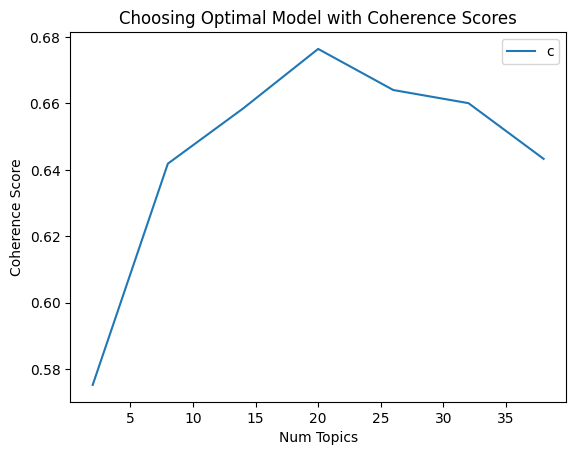

In [ ]:
# Show graph
limit=40; start=2; step=6; 
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence Score')
plt.legend(('coherence_values'), loc='best')
plt.title('Choosing Optimal Model with Coherence Scores')
plt.show()


In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print('Num Topics =', m, ' has Coherence Value of', round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5752
Num Topics = 8  has Coherence Value of 0.6418
Num Topics = 14  has Coherence Value of 0.6585
Num Topics = 20  has Coherence Value of 0.6764
Num Topics = 26  has Coherence Value of 0.664
Num Topics = 32  has Coherence Value of 0.6601
Num Topics = 38  has Coherence Value of 0.6433


Because the delta of coherence value from 2 topics to 8 topics is the largest, we are going to use 8 topics. Even though 14 topics has a slightly higher coherence score (.02 higher), adding 6 more topics of complexity to our forecasting model later on is not worth it for such a small gain in coherence.

In [ ]:
# Select the optimal model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=30))

[(0, '0.044*"set" + 0.042*"flower" + 0.033*"card" + 0.028*"silver" + 0.024*"cream" + 0.019*"pink" + 0.016*"ceramic" + 0.014*"paper_lantern" + 0.014*"jar" + 0.013*"blue_polkadot" + 0.013*"white" + 0.011*"blue" + 0.010*"heart" + 0.009*"purple" + 0.008*"glass" + 0.008*"party_pizza" + 0.008*"folding_umbrella" + 0.008*"paint" + 0.008*"wicker" + 0.008*"dish" + 0.007*"wood" + 0.007*"red" + 0.007*"egg_frye" + 0.007*"game" + 0.007*"tea_towel" + 0.007*"drawer" + 0.007*"small" + 0.007*"doll" + 0.006*"tier" + 0.006*"party"'), (1, '0.034*"blue" + 0.033*"large" + 0.027*"small" + 0.025*"star" + 0.025*"bottle" + 0.023*"pantry" + 0.019*"ivory" + 0.018*"frame" + 0.015*"hot_water" + 0.011*"light" + 0.010*"egg_cup" + 0.009*"flower_fairy" + 0.009*"bird" + 0.008*"set" + 0.008*"mini" + 0.007*"clear" + 0.007*"bowl" + 0.007*"candle" + 0.007*"reindeer" + 0.007*"tea" + 0.007*"glass" + 0.006*"balloon" + 0.006*"bag" + 0.006*"spoon" + 0.006*"yellow" + 0.006*"check" + 0.005*"triple" + 0.005*"spot" + 0.005*"chicken" 

In [ ]:
# Visualize the topics in the optimal lda model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word
)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.004103  0.045965       1        1  14.593491
3     -0.128648 -0.039687       2        1  13.346142
4      0.025219 -0.135309       3        1  12.835859
0     -0.016137  0.060517       4        1  12.796220
5      0.147439  0.147959       5        1  12.284583
7     -0.142153  0.096775       6        1  12.182237
1      0.142778 -0.083866       7        1  12.123952
2     -0.032602 -0.092355       8        1   9.837515, topic_info=               Term        Freq       Total Category  logprob  loglift
3              pink  281.000000  281.000000  Default  30.0000  30.0000
1236      retrospot   70.000000   70.000000  Default  29.0000  29.0000
41              set  402.000000  402.000000  Default  28.0000  28.0000
61       decoration   72.000000   72.000000  Default  27.0000  27.0000
504   red_retrospot   53.000000   53.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
2295     metal_door    9.346764   22.455511   Topic8  -4.8077   1.4425
41              set   35.241147  402.621056   Topic8  -3.4805  -0.1168
234          candle   11.609522   83.620371   Topic8  -4.5909   0.3445
29            heart   10.531499  160.839784   Topic8  -4.6883  -0.4071
10           design    6.531767   83.586781   Topic8  -5.1660  -0.2302

[420 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1464      3  0.694783    alarm_clock
630       2  0.930220         animal
629       5  0.907312          apple
399       4  0.940166  apples_design
335       1  0.793000            art
...     ...       ...            ...
379       3  0.053759           zinc
379       6  0.322552           zinc
1332      3  0.080553     zinc_heart
1332      8  0.886081     zinc_heart
827       2  0.898472     zinc_light

[703 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 5, 1, 6, 8, 2, 3])

<u>Find the dominant in each sentence</u>  

Now, we need to determine what topic a given document is about. To do this, we find the topic number that has the highest percentage contribution in that document. The `format_topics_sentences()` function nicely aggregates this information in a presentable table.

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=unique_docs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3,0.3891,"heart, design, green, set, holder, dolly_girl,...",15CM CHRISTMAS GLASS BALL 20 LIGHTS
1,1,6,0.7081,"pink, red, heart, rise, box, large, mirror, bl...",PINK CHERRY LIGHTS
2,2,0,0.7082,"set, flower, card, silver, cream, pink, cerami...",WHITE CHERRY LIGHTS
3,3,7,0.7083,"retrospot, decoration, red_retrospot, pink, se...","RECORD FRAME 7"" SINGLE SIZE"
4,4,0,0.1250,"set, flower, card, silver, cream, pink, cerami...",STRAWBERRY CERAMIC TRINKET BOX
5,5,6,0.5624,"pink, red, heart, rise, box, large, mirror, bl...",PINK DOUGHNUT TRINKET POT
6,6,2,0.7083,"set, sign, home, light, mug, light_holder, fre...",SAVE THE PLANET MUG
7,7,0,0.1250,"set, flower, card, silver, cream, pink, cerami...",FANCY FONT HOME SWEET HOME DOORMAT
8,8,4,0.5625,"set, garden, plate, necklace, tin, light, egg,...",CAT BOWL
9,9,4,0.7080,"set, garden, plate, necklace, tin, light, egg,...","DOG BOWL , CHASING BALL DESIGN"


This on its own is still pretty difficult to interpret (topic keywords may not be enough to make sense of what the topic is about) So, to help with understanding the topic, we can find the documents a given topic has contributed to the most and infer the ropic by reading that document. 

In [ ]:
# Group the top 5 sentences under each topic
sent_topics_sorted = pd.DataFrame()

sent_topics_grouped = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_grouped:
    sent_topics_sorted = pd.concat([sent_topics_sorted, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)],
                                   axis=0)
    
# Reset Index 
sent_topics_sorted.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorted.columns = ['Topic_Num', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
sent_topics_sorted

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0,0.8541,"set, flower, card, silver, cream, pink, cerami...",PURPLE TINT ACRYLIC FLOWER VASE
1,1,0.8541,"blue, large, small, star, bottle, pantry, ivor...",SMALL FOLDING SCISSOR(POINTED EDGE)
2,2,0.8541,"set, sign, home, light, mug, light_holder, fre...",MAGIC SHEEP WOOL GROWING FROM PAPER
3,3,0.8541,"heart, design, green, set, holder, dolly_girl,...",CLASSIC METAL BIRDCAGE PLANT HOLDER
4,4,0.8540,"set, garden, plate, necklace, tin, light, egg,...",SET 6 SCHOOL MILK BOTTLES IN CRATE
5,5,0.8540,"pack, set, polkadot, drawer_knob, hook, candle...",BASKET/8 SCENTED LOVE TOKEN CANDLES
6,6,0.8540,"pink, red, heart, rise, box, large, mirror, bl...",PINK/BLUE DISC/MIRROR STRING
7,7,0.8250,"retrospot, decoration, red_retrospot, pink, se...",FRIDGE MAGNETS LES ENFANTS ASSORTED


In [ ]:
for idx, kw in enumerate(sent_topics_sorted.Keywords):
    print(idx, kw)
    print('---')

0 set, flower, card, silver, cream, pink, ceramic, paper_lantern, jar, blue_polkadot
---
1 blue, large, small, star, bottle, pantry, ivory, frame, hot_water, light
---
2 set, sign, home, light, mug, light_holder, french, sticker, colour, kit
---
3 heart, design, green, set, holder, dolly_girl, metal, vintage, gold, earring
---
4 set, garden, plate, necklace, tin, light, egg, cushion_cover, candle, mini
---
5 pack, set, polkadot, drawer_knob, hook, candle, cake_case, tissue, vintage, key_re
---
6 pink, red, heart, rise, box, large, mirror, blue, black, beaker
---
7 retrospot, decoration, red_retrospot, pink, set, vintage, sign, white, assort, bowl
---


<u>Rationale for Classifications</u>  

<u>*Topic 0*:</u>  

1. Color Palette: The presence of words like "white," "silver," "cream," and "pink" suggests a focus on color, which is often associated with home decor and accessories.

1. Home-related Items: Words like "doormat," "cup," and "sticker" are often associated with items found in homes.

1. Garden Element: The word "garden" suggests a connection to outdoor or garden-related items, which can still fall under the broader category of home decor.

1. Set: The term "set" might indicate that these items are sold together as part of a collection, common in the context of home decor.

1. Heart: The word "heart" might be associated with decorative elements or items related to love and sentiment, fitting well with the theme of unique gifts.

Given these observations, the predicted category is "Home Decor and Accessories," where the company likely specializes in providing unique and stylish items for home decoration and personal use.

Predicted category: **Home Decor and Accessories**  

<u>*Topic 1*:</u>  

1. Color Palette: The words "red_retrospot," "vintage," "black," "blue_polkadot," and "pink" indicate a specific color palette associated with vintage and retro aesthetics.

1. Materials: The presence of "tin" and "metal" suggests items made from these materials, commonly used in crafting vintage-style decor.

1. Home Decor Elements: The words "frame," "clock," and "bucket" are indicative of home decor and accessories. Frames and clocks are classic decorative items, while a "tin seaside bucket" aligns with vintage-themed decor.

1. Sentimental Touch: The term "sweetheart" implies items with a sentimental or romantic touch, fitting well within the category of unique gifts.

1. Representative Sentence: The sentence "GIRLS VINTAGE TIN SEASIDE BUCKET" contains keywords like "vintage," "tin," and "seaside," reinforcing the association with vintage-inspired and coastal-themed decor.

Predicted category: **Vintage Home Decor and Accessories**  

<u>*Topic 2*:</u>  

1. Crafting and Design Elements: Keywords like "design," "large," "holder," and "set" suggest items related to crafting and design. The mention of "ribbon_reel" and "bunny" further emphasizes the creative and decorative nature of these items.

1. Decorative Themes: Terms such as "decoration," "dolly_girl," "ivory," and "hanging_heart" point towards decorative elements with a focus on aesthetics and design.

1. Artistic Touch: The inclusion of "bunny" implies a cute or whimsical aspect, aligning with artistic and creative themes commonly found in unique gifts.

1. Representative Sentence: The sentence "SET 12 RETRO WHITE CHALK STICKS" includes keywords like "set," "retro," and "white chalk sticks," suggesting artistic materials or decorative craft supplies.

Predicted category: **Artistic and Decorative Craft Supplies**  

<u>*Topic 3*:</u>  

1. Set: The term "set" suggests that the items are sold together as a collection or grouping. This could include multiple candles along with additional components.

1. Red: The color "red" indicates a specific color theme for the items. This suggests that the candles or related items are predominantly red in color.

1. Candle: The presence of the word "candle" indicates that the items are indeed related to candles. This aligns with the theme of a candle set.

1. Polkadot, Ceramic, Gold: These words provide additional characteristics of the items. "Polkadot" suggests a pattern, "ceramic" indicates a possible material, and "gold" may be a color or accent.

1. Light: The term "light" may emphasize that these items are associated with lighting, confirming the focus on candles.

1. Tray, Mini, Beaker: These words suggest additional accessories or components that may accompany the candle set, such as a tray, mini items, or a beaker.

Predicted category: **Decorative or Themed Candle Set**

<u>*Topic 4*:</u>  

1. Small: Indicates that the items are of a small size, possibly decorative or party-related accessories.

1. Retrospot: Suggests a retro or vintage spotted pattern, which is commonly associated with party and decorative items.

1. Pink, Purple: Color indicators. Pink and purple are colors often associated with festive and decorative items, especially in the context of gifts.

1. Bottle: Could refer to decorative bottles, possibly containing party favors or decorative elements.

1. Heart: Implies that some items in this category may have a heart shape, commonly used in decorative and gift-related items.

1. Paper Lantern: A specific item mentioned that is often associated with decorative lighting for parties or events.

1. Gift Bag: Indicates the presence of gift bags, commonly used for packaging small gifts and party favors.

1. Drawer: While less common, the term "drawer" could suggest a decorative drawer or container for storing small items.

1. Hot Water: Although seemingly unrelated, it might be an outlier or part of a specific product name. Alternatively, it could relate to items associated with warm beverages in a festive context.

1. Assorted: The term "assorted" in the most representative sentence suggests a variety of items, reinforcing the idea of a collection of party and decorative items.

Predicted category: **Assorted Party and Decorative Items**  

<u>*Topic 5*:</u>   

1. Green, Pink: Color indicators. Green and pink are often associated with artistic and vibrant home decor items.

1. Necklace: Indicates the presence of a wearable accessory, possibly a decorative necklace.

1. Hang, Decoration: Suggests items designed for hanging and decoration, aligning with home decor and accessory categories.

1. Plate: Could refer to a decorative plate, commonly used in home decor.

1. Key_Re (Key Ring): While the term is truncated, "key_re" likely refers to a key ring, a small decorative item often associated with home decor and accessories.

1. Wrap: Implies that some items may be gift-worthy or come with decorative packaging.

1. Jar: Might indicate a decorative jar, commonly used for storing small items or as a decorative element.

1. Letter_Ble (Letter B): Possibly indicates a decorative item related to the letter 'B', which could be part of a personalized or alphabet-themed home decor item.

1. Painted Sea Shell Metal Windchime: The most representative sentence provides additional context, suggesting a specific item in the category—painted sea shell metal windchime. Windchimes are often considered decorative and artistic elements for homes.

Predicted category: **Artistic Home Decor and Accessories**  

<u>*Topic 6*:</u>  

1. Heart, Star: These shapes are commonly used in decorative elements for gift wrapping and presentation.

1. Blue, Pink: Colors often associated with various occasions, including those for which gifts are exchanged.

1. Card, Sign: Suggestive of items used for creating personalized gift cards or signs for special occasions.

1. Pack, Set: Indicators of items available in packs or sets, common in gift wrapping materials.

1. Drawer_Knob: While less common, decorative drawer knobs could be used in the context of gift packaging or decorative boxes.

1. Pantry: May suggest items like decorative labels or tags used in gift presentation.

Predicted category: **Retro-inspired Kitchen or Home Decor Gifts**

<u>*Topic 7*:</u>

1. Pink, Blue: Colors commonly associated with home decor and floral arrangements.

1. Flower, Rose: Direct references to floral elements, indicating a focus on botanical or floral-themed items.

1. Box, Cushion Cover: Suggestive of home decor items, such as decorative boxes or cushion covers with floral designs.

1. Rise, Table: Implies items that could be used for tabletop decor, such as flower arrangements or art pieces.

1. Classic: Suggests a timeless and sophisticated style, often associated with artistic and decorative elements in home decor.

1. Home: Indicates items designed for home use or decoration.

1. Paper: Could be related to art prints, floral-themed paper products, or decorative paper used in home decor.

1. MEDIUM WHITE/PINK ROSE ART FLOWER: The most representative sentence aligns with the theme, describing a medium-sized artistic floral arrangement in white and pink.

Predicted category: **Home Decor and Artistic Floral Arrangements**


In [ ]:
# Now that we have our categories, let's map them to our descriptions.
categories = {0:'Home Decor/Accessories', 1:'Vintage Home Decor/Accessories', 2:'Artistic/Decorative Craft Supplies',
              3:'Decorative/Themed Candle Set', 4:'Assorted Party/Decorative Items', 5:'Artistic Home Decor/Accessories',
              6:'Retro-inspired Kitchen or Home Decor Gifts', 7:
              'Home Decor/Artistic Floral Arrangements'}

# Get the document-topic distribution
all_topics = optimal_model.get_document_topics(corpus, minimum_probability=0.0)

# Convert the distribution to a DataFrame
all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()
all_topics_df = pd.DataFrame(all_topics_numpy)


# Display the DataFrame
all_topics_df['descriptions'] = unique_docs

# Create a new column with the maximum value and the corresponding column name
all_topics_df['topic'] = all_topics_df.iloc[:, :-1].apply(lambda row: row.idxmax(), axis=1)
all_topics_df['topic'] = all_topics_df['topic'].map(categories)

# Create a dictioanry to map 'descriptions' to keys and 'topic' to values
topic_to_description = all_topics_df.set_index('descriptions')['topic'].to_dict()

In [ ]:
all_topics_df.head()

,0,1,2,3,4,5,6,7,descriptions,topic
0,0.041688,0.041738,0.360755,0.389057,0.041751,0.041670,0.041672,0.041670,15CM CHRISTMAS GLASS BALL 20 LIGHTS,Decorative/Themed Candle Set
1,0.041792,0.041693,0.041678,0.041695,0.041678,0.041691,0.708085,0.041688,PINK CHERRY LIGHTS,Retro-inspired Kitchen or Home Decor Gifts
2,0.708182,0.041679,0.041672,0.041679,0.041672,0.041678,0.041703,0.041736,WHITE CHERRY LIGHTS,Home Decor/Accessories
3,0.041670,0.041670,0.041670,0.041671,0.041670,0.041670,0.041670,0.708312,"RECORD FRAME 7"" SINGLE SIZE",Home Decor/Artistic Floral Arrangements
4,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,STRAWBERRY CERAMIC TRINKET BOX,Home Decor/Accessories


In [ ]:
# Map the topics to descriptions in the main dataframe
retail_data['topic'] = retail_data['description'].map(topic_to_description)

In [ ]:
retail_data.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country,revenue,month,topic
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,medium_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,83.4,December,Decorative/Themed Candle Set
1,489434,79323P,PINK CHERRY LIGHTS,medium_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,81.0,December,Retro-inspired Kitchen or Home Decor Gifts
2,489434,79323W,WHITE CHERRY LIGHTS,medium_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,81.0,December,Home Decor/Accessories
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",high_quantity,2009-12-01 07:45:00,low_price,13085.0,United Kingdom,100.8,December,Home Decor/Artistic Floral Arrangements
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,high_quantity,2009-12-01 07:45:00,very_low_price,13085.0,United Kingdom,30.0,December,Home Decor/Accessories


In [ ]:
# Make sure there are no null values for topic
retail_data['topic'].isna().sum()

0

Because we have no na values for the `topic` column, this means we have successfully mapped all topics to our descriptions for our entire retail dataset.

## Exploratory Data Analysis (EDA)
---


To begin EDA, I am going to perform a univartiate analysis on variables that might give me more information on specific demographics. 

### Analyzing Country Distribution at the Store Level

In [ ]:
# Create category counts and make sure that this is the number of unique customers
# per country not just the number of orders
unique_country_counts = (
    retail_data.groupby("country")["customer_id"].nunique().sort_values(ascending=False)
)
print(unique_country_counts)

country
United Kingdom    5354
Other              530
Name: customer_id, dtype: int64


When looking at the unique category counts for country, we can immediately see that the overwhelming majority country is the United Kingdom, followed by Germany, France, Spain, and then everything else. Any way we choose to visualize this, it will look very messy (overlap of labels and metrics). To mitigate this problem, I will create a donut chart with a threshold that classifies anything country with less than 41 users as 'Other'. This also tells us that between 2009-2011, 5970 retail stores/whole salers/resellers accrue over 1 million transactions. 

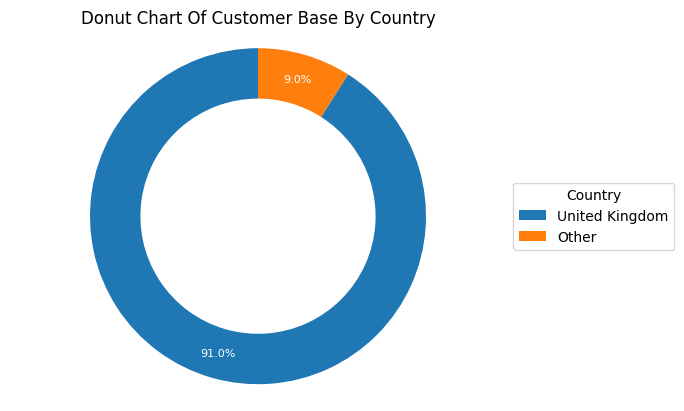

In [ ]:
# Plot donut chart for countries distribution
plot_donut_chart(
    unique_country_counts,
    title="Donut Chart of Customer Base by Country",
    legend="country",
)

The U.K. sweeps all other countries with a majority percenteage of 91.0%. The second largest customer base is Other at 9.0% accounting for 40 different countries.

### Analyzing the Frequency of Transactions per month.


In [ ]:
# Count the number of orders for each month
month_counts = retail_data["month"].value_counts()
print(month_counts)

month
November     157133
October      115596
December     109439
September     89565
March         75408
June          74227
July          70530
May           69422
August        66494
January       64394
April         61791
February      54893
Name: count, dtype: int64


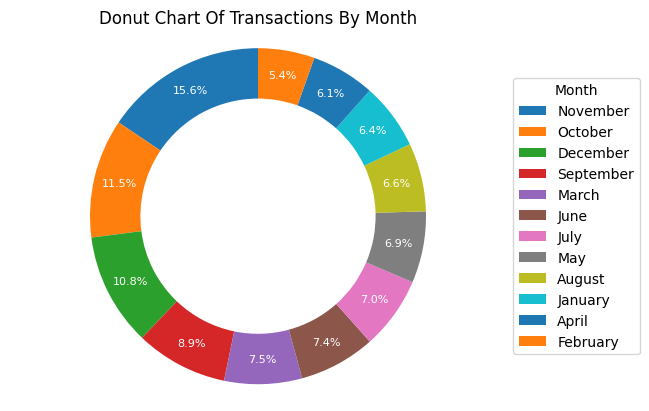

In [ ]:
# Plot donut chart illustrating transaction distribution by month
plot_donut_chart(
    month_counts,
    title="Donut Chart of Transactions by Month",
    legend="month",
    threshold=41,
)

According to out dataset, the highest volume of transactions occurs in the months November, October, and December. I think this makes sense because the U.K.-based store we are analyzing sells gifts and the majority of gift giving holidays occur at the end of the year.

### Analyzing the Distribution of Topics

In [ ]:
# Count number of orders for each topic
topic_counts = retail_data['topic'].value_counts()
print(topic_counts)

topic
Home Decor/Accessories                        179636
Artistic Home Decor/Accessories               133598
Home Decor/Artistic Floral Arrangements       131592
Assorted Party/Decorative Items               123345
Decorative/Themed Candle Set                  116994
Vintage Home Decor/Accessories                112589
Artistic/Decorative Craft Supplies            111270
Retro-inspired Kitchen or Home Decor Gifts     99868
Name: count, dtype: int64


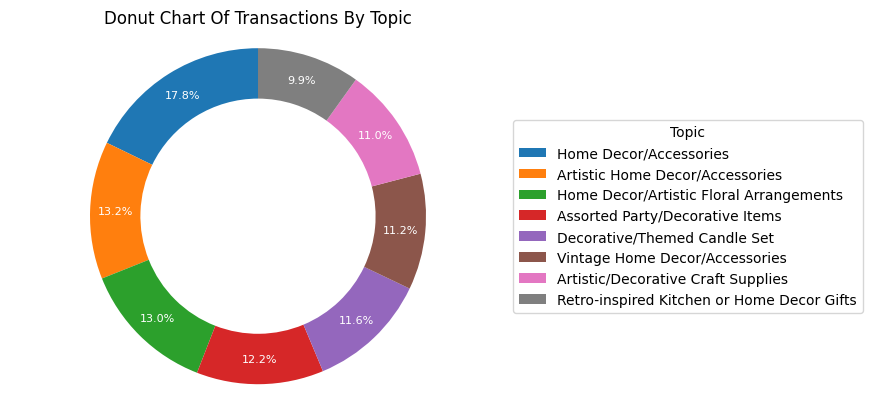

In [ ]:
# Plot donut chart analyzing how often each topic category was purchased
plot_donut_chart(
    topic_counts,
    title="Donut Chart of Transactions by Topic",
    legend="topic"
)

This donut chart shows us that the most commonly purchasesd item categories from the U.K. store are 'Home Decor/Accessories', 'Decorative/Themed Candle Set', and 'Vintage Home Decor/Accessories'. These are all home related items and probably tangentially related in terms of our LDA topic model.

### Analyzing Diustribution of Quantities Purchased 

In [ ]:
# Count number of orders for each quantity cateogry
quantity_counts = retail_data['quantity'].value_counts()
print(quantity_counts)


quantity
low_quantity       503355
medium_quantity    371088
high_quantity      134449
Name: count, dtype: int64


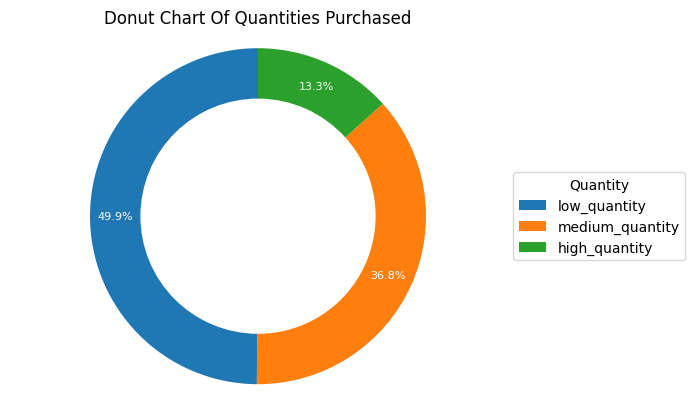

In [ ]:
# Plot donut chart analyzing the distriubtion of quantity categories we defined 
plot_donut_chart(
    quantity_counts,
    title="Donut Chart of Quantities Purchased",
    legend="quantity",
)

This donut chart shows us that customers most commonly buy low quantities, medium quantities, and high quantities of gifts, in that order. To break down the proportions more analytically:

- 49.9% of purchases were a low quantity (1-3) of items.
- 36.8% of purchases were a medium quantity (3-12) of items.
- 13.3% of purchases were a high quantity (12-80,996) of items.


### Analyzing Diustribution of Prices sold

In [ ]:
# Count number of orders for each price cateogry
price_counts = retail_data['price'].value_counts()
print(price_counts)


price
very_low_price    304053
high_price        251066
low_price         227507
medium_price      226266
Name: count, dtype: int64


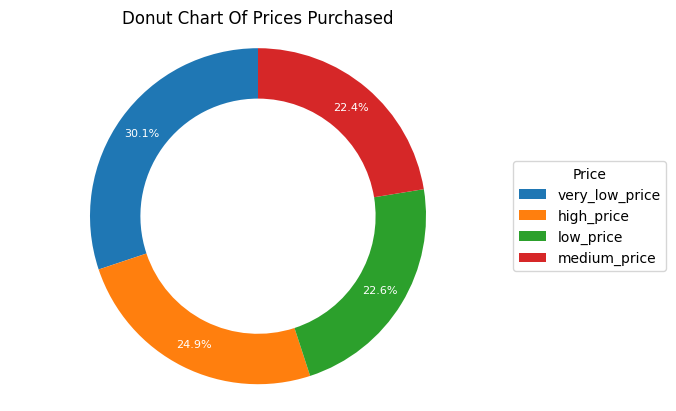

In [ ]:
# Plot donut chart analyzing the distriubtion of price categories we defined 
plot_donut_chart(
    price_counts,
    title="Donut Chart of Prices Purchased",
    legend="price",
)

Here, this donut chart illustrates that customers most commonly tend to buy very low price items, low price items, high price items, low price items, and medium price items, in that order. To break down these categories analytically:

- 30.1% of the purchases were very low priced (0£-1.25£) items.
- 24.9% of the purchases were high priced (4.13£-25111.90£) items.
- 22.6% of the purchases were low priced (1.25£-2.10£) items.
- 22.4% of the purchases were medium priced (2.10£-4.13£) items.

## Customer Segmentation using K-Modes Clustering
---

While the traditional K-Means clustring algorithm does a great job with continuous numeric data, it does not work well for variable data which is the format I would like to use. I think it will be easier to intuitively categorize customer clusters by combinations of categories (i.e. 'medium price, high quantity, U.K., and 'Home Decor/Accessores'). Fortunately, there is an approach well-tailored for this task called "K-Modes clustering".

K-Modes (proposed by Huang, Z in 1997) uses a measure of dissimilarity for categorical objects and iterates over clusters, choosing new modes each time with the aim of minimizing the measure of dissimilarity. Just like any other clustering approach, I need to decide when to stop with segmenting the data into clusters, choosing an optimal number of clusters. The best way to do this is by evaluating an Elbow Plot.

In [ ]:
# Create a relevant subset of retail_data that you want to cluster on
cluster_input = retail_data[['quantity', 'price', 'country', 'month', 'topic']]

In [ ]:
cluster_input.head()

,quantity,price,country,month,topic
0,medium_quantity,high_price,United Kingdom,December,Decorative/Themed Candle Set
1,medium_quantity,high_price,United Kingdom,December,Retro-inspired Kitchen or Home Decor Gifts
2,medium_quantity,high_price,United Kingdom,December,Home Decor/Accessories
3,high_quantity,low_price,United Kingdom,December,Home Decor/Artistic Floral Arrangements
4,high_quantity,very_low_price,United Kingdom,December,Home Decor/Accessories


KModes started at 2023-10-18 01:12:18.912050
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 2973293.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 98411, cost: 2557809.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 2494774.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 2306008.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing

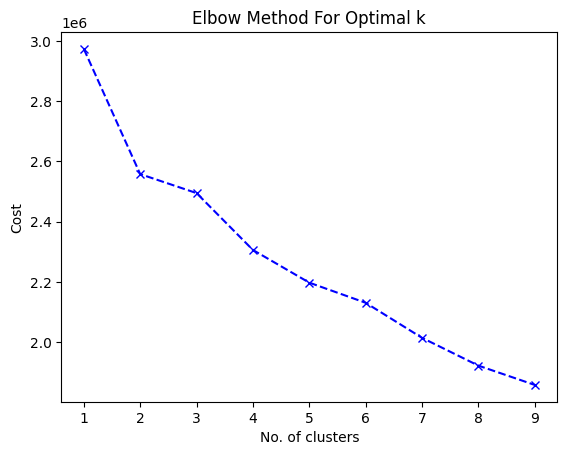

In [ ]:
print(f'KModes started at {pd.Timestamp.now()}')

# Use an elbow curve to find the optimal k
cost = []
k = range(1,10)
for num_clusters in list(k):
    kmode = KModes(n_clusters=num_clusters, n_init=5, verbose=1)
    kmode.fit_predict(cluster_input)
    cost.append(kmode.cost_)

print(f'Completed at {pd.Timestamp.now()}')

plt.plot(k, cost, 'bx--')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

The result of our Elbow Plot indicates that 4 clustrers is a good number to go with. The pace of the decline in the cost metric slows significantly after 4 clusters.  

With 4 clusters decided, we will re-run the K-Modes clustering specifying 4 clusters.

In [ ]:
# Fit optimal K-Modes model with 4 clusters
kmode_opt = KModes(n_clusters=4, n_init=5, verbose=1)
cluster_assignmnets = kmode_opt.fit_predict(cluster_input)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 2306008.0


In [ ]:
# Add cluster assignments back to the original dataframe
retail_data['cluster'] = cluster_assignmnets

In [ ]:
retail_data.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country,revenue,month,topic,cluster
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,medium_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,83.4,December,Decorative/Themed Candle Set,1
1,489434,79323P,PINK CHERRY LIGHTS,medium_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,81.0,December,Retro-inspired Kitchen or Home Decor Gifts,1
2,489434,79323W,WHITE CHERRY LIGHTS,medium_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,81.0,December,Home Decor/Accessories,1
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",high_quantity,2009-12-01 07:45:00,low_price,13085.0,United Kingdom,100.8,December,Home Decor/Artistic Floral Arrangements,2
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,high_quantity,2009-12-01 07:45:00,very_low_price,13085.0,United Kingdom,30.0,December,Home Decor/Accessories,0


### Visualizing the Distribution of Our Clusters

In [ ]:
# Count the number of orders for each cluster
cluster_counts = retail_data['cluster'].value_counts()
print(cluster_counts)

cluster
0    526103
1    236042
3    154137
2     92610
Name: count, dtype: int64


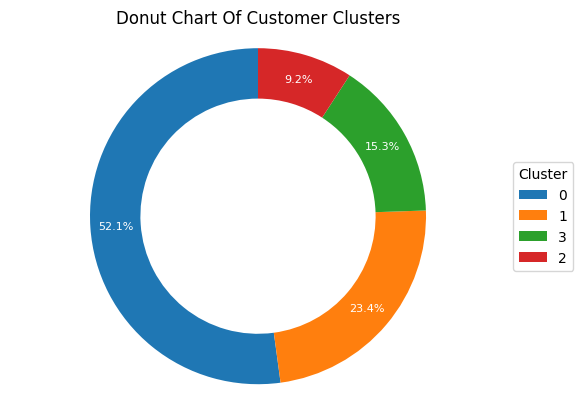

In [ ]:
# Plot a donut chart visualizing the distribution of our 4 clusters
plot_donut_chart(
    cluster_counts,
    title="Donut Chart of Customer Clusters",
    legend="cluster",
)

In [636]:
kmode_opt.cluster_centroids_

array([['low_quantity', 'very_low_price', 'United Kingdom', 'November',
        'Home Decor/Accessories'],
       ['medium_quantity', 'high_price', 'United Kingdom', 'October',
        'Artistic Home Decor/Accessories'],
       ['high_quantity', 'low_price', 'United Kingdom', 'December',
        'Home Decor/Artistic Floral Arrangements'],
       ['low_quantity', 'high_price', 'United Kingdom', 'December',
        'Assorted Party/Decorative Items']], dtype='<U39')